# Experimentation
## Azure ML Compute and MLFlow tracking

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import mlflow 
import mlflow.sklearn

# load data

def get_data():
    df = pd.read_csv('../data/hour.csv')
    X = df[['hr', 'temp', 'hum', 'windspeed','workingday', 'weathersit' ]].copy()

    X['hr_sin'] =  X['hr'].apply(lambda x: np.sin(2 * np.pi * x / 24))
    X['hr_cos'] =  X['hr'].apply(lambda x: np.cos(2 * np.pi * x / 24))
    X['temp2'] = (X['temp'] - 0.6)**2
    y = df['cnt']
    return X,y

def encode_cols(X, cols):
    mlflow.log_param('encoded_columns', cols)
    encoder = OneHotEncoder(sparse=False)
    X_encoded = encoder.fit_transform(X[cols])
    X.drop(cols, axis=1, inplace=True)
    X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cols))
    Xe = pd.concat([X, X_encoded], axis=1)
    return Xe

def solve(model, X, y):
    mlflow.sklearn.autolog()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', rmse)
    mlflow.log_metric('rmse', rmse)

    # plot the predicted vs. actual values
    fig , ax = plt.subplots(1)
    ax.scatter(y_test, y_pred, s=2, alpha=0.5)
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title('Predicted vs. Actual Values')
    fig.show()
    mlflow.log_figure(fig, 'pred-actual.png')
    return model



/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2023/04/26 12:36:06 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/26 12:36:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way 

Root Mean Squared Error: 132.31050297503828
Root Mean Squared Error: 76.90347783551329
Root Mean Squared Error: 80.41458901591314


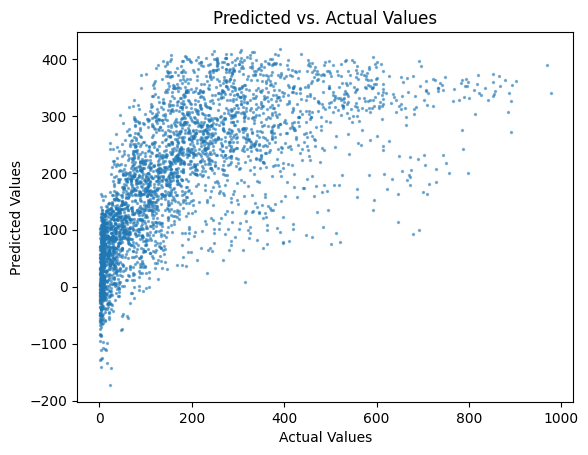

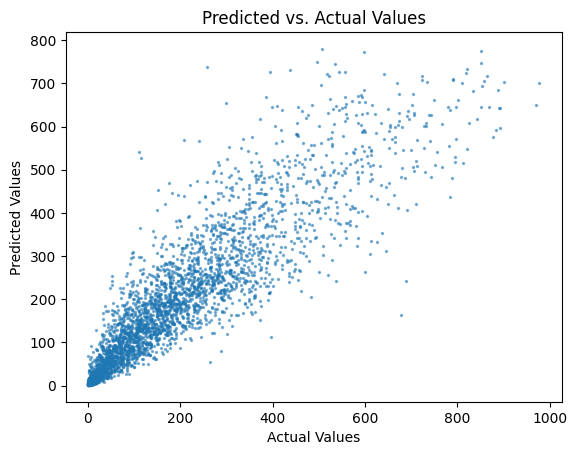

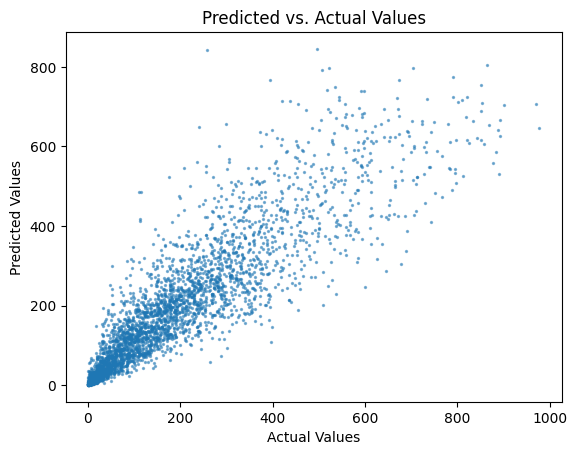

In [3]:
import re 

mlflow.set_experiment('bike-share-exp')
models = [LinearRegression(), RandomForestRegressor(n_estimators=100),RandomForestRegressor(n_estimators=10)]

for m in models:
    mname = re.sub(".*'(.*)'.*", r'\1', str(type(m)) )
    with mlflow.start_run(run_name='notebook-'+mname) as run:
        X,y = get_data()
        Xe = encode_cols(X, ['workingday', 'weathersit'])
        model = solve (m, Xe, y)
        mlflow.register_model(f'runs:/{run.info.run_id}/model', mname)